# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2022-2023
$$\require{mhchem}$$  
$$\require{dcolumn}$$
$$\require{longtable}$$
$$\require{array}$$
$$\require{multirow}$$


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.integrate import odeint
from scipy.special import gammaln, digamma, polygamma

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 9, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{eqnarray*}
&&(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
&&(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
&&(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
&&(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{eqnarray*}
We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

#### Question 1
1. Adapt the Gillespie code from week 10 exercises to simulate the Telegraph model. Use the template below that also contains initial values.
2. Discuss whether the proposed initial rates are relevant biologically. 
3. Vary the different rates, plot representative traces and comment. Try to find cases that show qualitatively different regimes of the model.


#### Gillespie template

In [2]:
def gillespie(g_ini,n_ini,t_ini,syn_rate,deg_rate,on_rate,off_rate) :
    
    """
    Implementation of the Gillespie algorithm for a two-state model for the gene promoter.
    
    Args:
        g_ini : The initial state of the promoter (On/Off)
        n_ini : The initial number of mRNA molecules
        t_ini : The time at the start of the experiment
        syn_rate : synthesis rate for the mRNA molecules
        deg_rate : degradation rate for the mRNA molecules
        on_rate : The promoter switch rate towards an active state (g==1)
        off_rate : The promoter switch rate towards an inactive state (g==0)
    
    Returns :
        tprint : Equally spaced timestamps of the events
        nprint : A list containing the evolution of the number of molecules throughout the experiment
        gprint : A list containing the evolution of promoter state throughout the experiment    
    
    """
    
    #initial conditions for the state (g,n) at time t
    g = g_ini
    n = n_ini 
    t = t_ini
    
    tp = 0
    DT = 0.01
    t_end = 1000 #min
    
    nprint = []
    gprint = []
    tprint = []
    
    s = syn_rate # number of initiations per minute
    k = deg_rate # 1/k = 50 min
    k_off = off_rate #t_on = 1/k_off = 15 min
    k_on  = on_rate #t_off = 1/k_on = 120 min
    
    while t < t_end:
    
        
        if g == 1:
            rates = [k*n,s,k_off]  
            
        else:       
            rates = [k*n,k_on]
        
        rates_tot = sum(rates)   
        dt = np.random.exponential(scale=1/rates_tot)
        t += dt
        
        rand_uniform = np.random.random()
        
        if g == 1 : 
        
            if rand_uniform <= (rates[0] / rates_tot) :
                n -= 1
                
            elif rand_uniform <= ( (rates[0] + rates[1]) / rates_tot) :
                n += 1     
            else :
                g = 0
                
        elif g == 0 :
            
            if rand_uniform <= rates[0] / rates_tot :
                n-=1
            else :
                g = 1
        
        #this is to have equally spaced output times
        while tp<t and t<=t_end:
            nprint.append(n)
            gprint.append(g)
            tprint.append(tp)
            tp += DT
            
    return tprint,nprint, gprint

## Answer 1 

### 1.  
See the "Gillespie Template" cell above.

### 2. 
The proposed 4 initial rates are given by :
- $s = 50$
- $k_{degradation} = 0.02$
- $k_{on} = \frac{1}{15}$
- $k_{off} = \frac{1}{120}$

According to lectures 9 and 10, most genes are transcribed at $s=1 new copy per hour. However, the maximum possible initiation rate per allele is 1.6~2 per second. This adds up to a maximum of around 60 per hour. $s is initialized to 50 which is quite high but however remains in the range of possible values which makes it considerable to be a relevant value biologically.
In terms of rate of degradation, the range of values is quite large as the half-life of mRNA molecules varies depending on the cell. The 0.02 value can also then be considered as biologically relevant.
For the activation and inactivation rates, we can see that the inactivation rate is 8 times faster than the activateion rate. This complies with the transcription phenomena which is known to be quite rare and justifies why the promoter is mostly switching from the active to the inactive state.
Hence, we can safely say that the initial values provided are biologically relevant.

In [3]:
### Defining our default rates
g = 1
n = 20 
t = 0
s = 50 # number of initiations per minute
k = 0.02 # 1/k = 50 min
k_on  = 1/120 #t_off = 1/k_on = 120 min
k_off = 1/15 #t_on = 1/k_off = 15 min

#Running the gillespie algorithm with our default rates
tprint,nprint,gprint = gillespie(g,n,t,s,k,k_on,k_off)

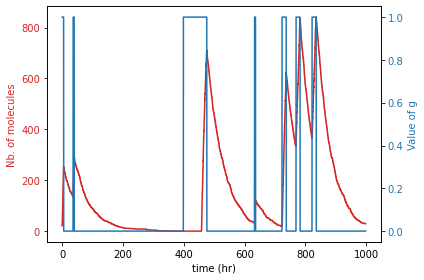

In [4]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (hr)')
ax1.set_ylabel('Nb. of molecules', color=color)
ax1.plot(tprint, nprint, color=color)
ax1.tick_params(axis='y', labelcolor=color)


#If you only want to see the number of molecules and not the g values, comment all the lines below besides the last two

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Value of g', color=color)  # we already handled the x-label with ax1
ax2.plot(tprint, gprint, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

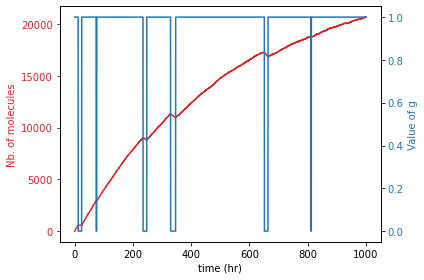

In [6]:
### Defining other rates
g = 1
n = 20
t = 0
s = 50 # number of initiations per minute
k = 0.002 # 1/k = 50 min
k_on  = 1/10
k_off = 1/120

#Running the gillespie algorithm with our default rates
tprint,nprint,gprint = gillespie(g,n,t,s,k,k_on,k_off)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (hr)')
ax1.set_ylabel('Nb. of molecules', color=color)
ax1.plot(tprint, nprint, color=color)
ax1.tick_params(axis='y', labelcolor=color)


#If you only want to see the number of molecules and not the g values, comment all the lines below besides the last two

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Value of g', color=color)  # we already handled the x-label with ax1
ax2.plot(tprint, gprint, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

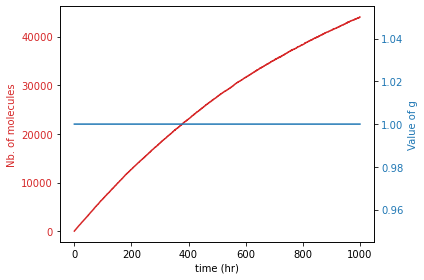

In [27]:
### Defining our default rates
g = 1
n = 20
t = 0
s = 70 # number of initiations per minute
k = 0.001 # 1/k = 50 min
k_on  = 1/10
k_off = 1/1000

#Running the gillespie algorithm with our default rates
tprint,nprint,gprint = gillespie(g,n,t,s,k,k_on,k_off)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (hr)')
ax1.set_ylabel('Nb. of molecules', color=color)
ax1.plot(tprint, nprint, color=color)
ax1.tick_params(axis='y', labelcolor=color)


#If you only want to see the number of molecules and not the g values, comment all the lines below besides the last two

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Value of g', color=color)  # we already handled the x-label with ax1
ax2.plot(tprint, gprint, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

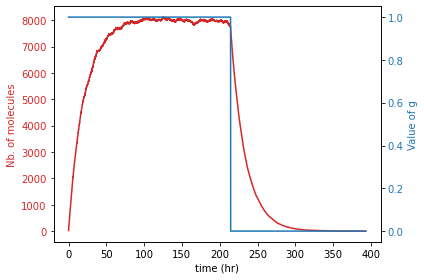

In [76]:
### Defining our default rates
g = 1
n = 20 
t = 0
s = 400 # number of initiations per minute
k = 0.05 # 1/k = 50 min
k_on  = 1/10000 #t_off = 1/k_on = 120 min
k_off = 1/200  #t_on = 1/k_off = 15 min

#Running the gillespie algorithm with our default rates
tprint,nprint,gprint = gillespie(g,n,t,s,k,k_on,k_off)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (hr)')
ax1.set_ylabel('Nb. of molecules', color=color)
ax1.plot(tprint, nprint, color=color)
ax1.tick_params(axis='y', labelcolor=color)


#If you only want to see the number of molecules and not the g values, comment all the lines below besides the last two

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Value of g', color=color)  # we already handled the x-label with ax1
ax2.plot(tprint, gprint, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Question 2
1. Study the distribution of mRNA numbers, what type of distribution do you expect/observe?
2. Identify a regime where you find the Poisson distribution. Explain.
3. Identify a regime where you find another distribution, for example the Negative Binomial.
4. In both cases, discuss how the model parameters relate to the parameters of the distributions.
5. Find a situation where the distribution is bimodal. Explain.

####  Poisson and Negative binomal distributions

In [77]:
#  poisson distribution
def Poisson(lam, counts):
    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

# negative binomial distribution
def convert_params(mu, theta):
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def pmf(counts, mu, theta):
    return nbinom.pmf(counts, *convert_params(mu, theta))

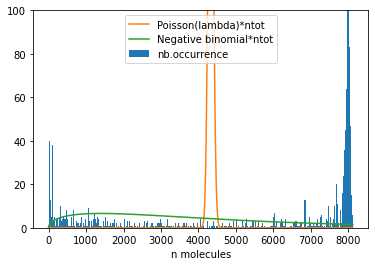

In [78]:
#remove a suitable transient and plot the histogram
plt.hist(nprint,bins = max(nprint), label='nb.occurrence')
ntot=len(nprint)
nn = np.arange(np.max(nprint))

# poisson distribution
lam=np.mean(nprint) # Change lambda to fit the histogramm
p=Poisson(lam, nn)
p=p*ntot
plt.plot(nn, p, label='Poisson(lambda)*ntot')

# neg binomial distribution
variance = np.var(nprint)
theta = (lam+lam**2)/variance
b=pmf(np.arange(np.max(nprint)), lam, theta)*ntot
plt.plot(np.arange(np.max(nprint)), b, label='Negative binomial*ntot')

plt.xlabel("n molecules")
ax = plt.gca()
ax.set_ylim([0, 100])

plt.legend()
plt.show()

### Answer 2.

#### 1. mRNA distributions
For a Random Telegraph process with biologically accurate rates, we'd expect the mRNA levels to greatly vary, under the form of "bursts" (transcriptional bursts), which would lead to a Negative binomial distribution of the mRNA numbers. This is indeed what we observe (j'espère mdr) in our case.

#### 2. Poisson distribution
A poisson distribution can simply be observed when setting our $g_{on}$ to 1 and the $g_{off}$ to 0. By doing this, our model is reduced to the constitutive model seen earlier in the course. In that case, the mRNA levels are indeed distributed following a poisson's law.

#### 3. Negative Binomial distribution
As explained in part 1 of answer 2, some biologically accurate rates will lead to transcriptional bursts, and thus to a negative binomial distribution of the mRNA levels.

#### 4. Bimodal distribution
je sais pas tro, j'essaye de trafiquer avec les rates mais je tombe jamais sur qqch de vraiment bien bimodal, regarder la littérature pour voir comment on peut obtenir ça ?